In [1]:
import matplotlib
matplotlib.use('Agg')

import collections
import numpy as np
import os
import h5py
from scipy.stats import zscore
import pyret.filtertools as ft
import pyret.spiketools as sp
import pyret.stimulustools as st
from deepretina.toolbox import load_model, load_partial_model, rolling_window
from deepretina.io import despine
from deepretina.metrics import cc
from scipy.interpolate import interp1d
from scipy.signal import detrend

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.style.use('deepretina')

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'seismic'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)
Using Theano backend.


You must install GPy (pip install GPy) to fit the GP regression nonlinearity.


In [2]:
data_dir = os.path.expanduser('~/data/kastner/')
early_h_file = 'horizontals_early_2012.h5'
late_h_file = 'horizontals_late_2012.h5'
early_a_file = 'amacrines_early_2012.h5'
late_a_file = 'amacrines_late_2012.h5'

# Horizontal cells

In [15]:
h_rfs = collections.defaultdict(list)
h_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + early_h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        print(np.array(f['lines/time']).shape)
        h_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        detrended_mem_pot = np.array(f['lines/detrended_membrane_potential'])[ide]
        stimuli = np.array(f['lines/stimuli'])
        h_recreated_rf = np.zeros_like(h_rfs[expt])
        window_size = h_rfs[expt].shape[0]
        for t in range(window_size, len(detrended_mem_pot)):
            h_recreated_rf += stimuli[(t-window_size):t].astype('float') * detrended_mem_pot[t]
        h_recreated_rf /= (len(detrended_mem_pot) - window_size)
        h_recreated_rfs[expt] = h_recreated_rf[::-1]

1it [00:00,  5.68it/s]

(16192,)
(16192,)

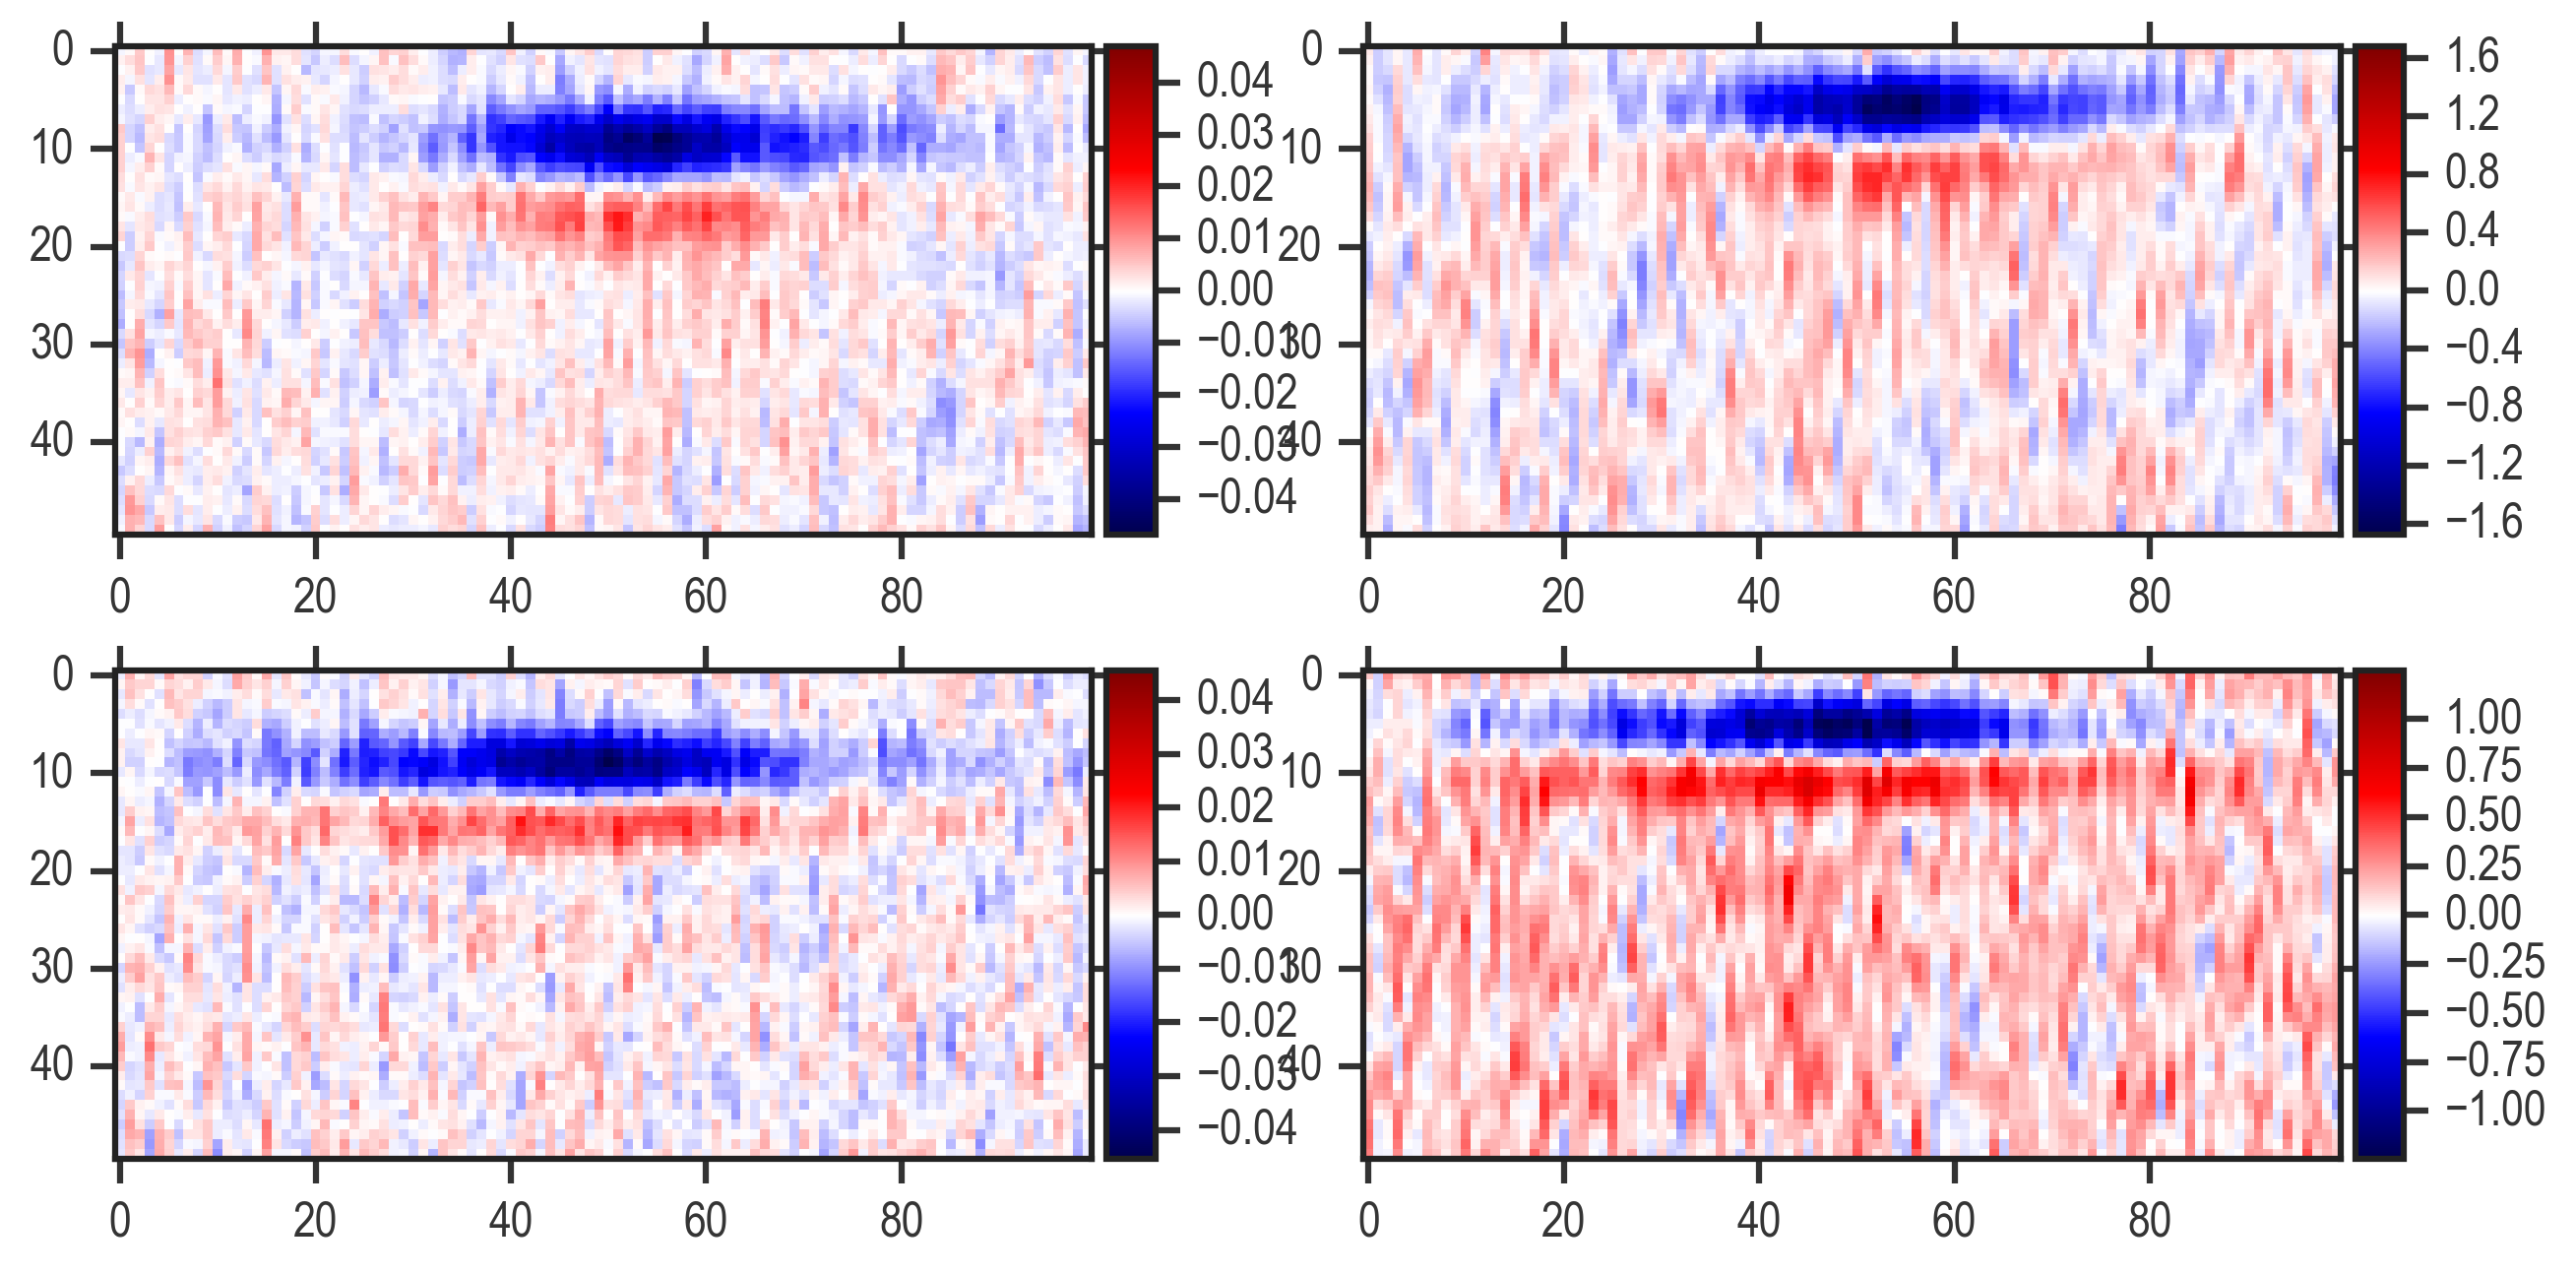

In [17]:
fig = plt.gcf()
fig.set_size_inches((10,5))
num_expts = len(h_rfs.keys())
for ide, expt in enumerate(sorted(h_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(h_rfs[expt], clim=[-np.max(abs(h_rfs[expt])), np.max(abs(h_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(h_recreated_rfs[expt], clim=[-np.max(abs(h_recreated_rfs[expt])),
                                                           np.max(abs(h_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

Without detrending

In [48]:
window_size = 200

h_rfs = collections.defaultdict(list)
h_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + early_h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        h_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        mem_pot = np.array(f['lines/membrane_potential'])[ide]
        smoothed_mem_pot = np.zeros_like(mem_pot)

        for t in range(len(mem_pot)):
            start = np.max([0, (t-window_size//2)])
            stop = np.min([len(mem_pot)-1, (t+window_size//2)])
            smoothed_mem_pot[t] = np.mean(mem_pot[start:stop])
        stimuli = np.array(f['lines/stimuli'])
        h_recreated_rf = np.zeros_like(h_rfs[expt])
        window_size = h_rfs[expt].shape[0]
        for t in range(window_size, len(mem_pot)):
            h_recreated_rf += stimuli[(t-window_size+1):t+1].astype('float') * (mem_pot[t] - smoothed_mem_pot[t])
        h_recreated_rf /= (len(mem_pot) - window_size)
        h_recreated_rfs[expt] = h_recreated_rf[::-1]

1it [00:00,  1.65it/s]

(16192,)
(16192,)

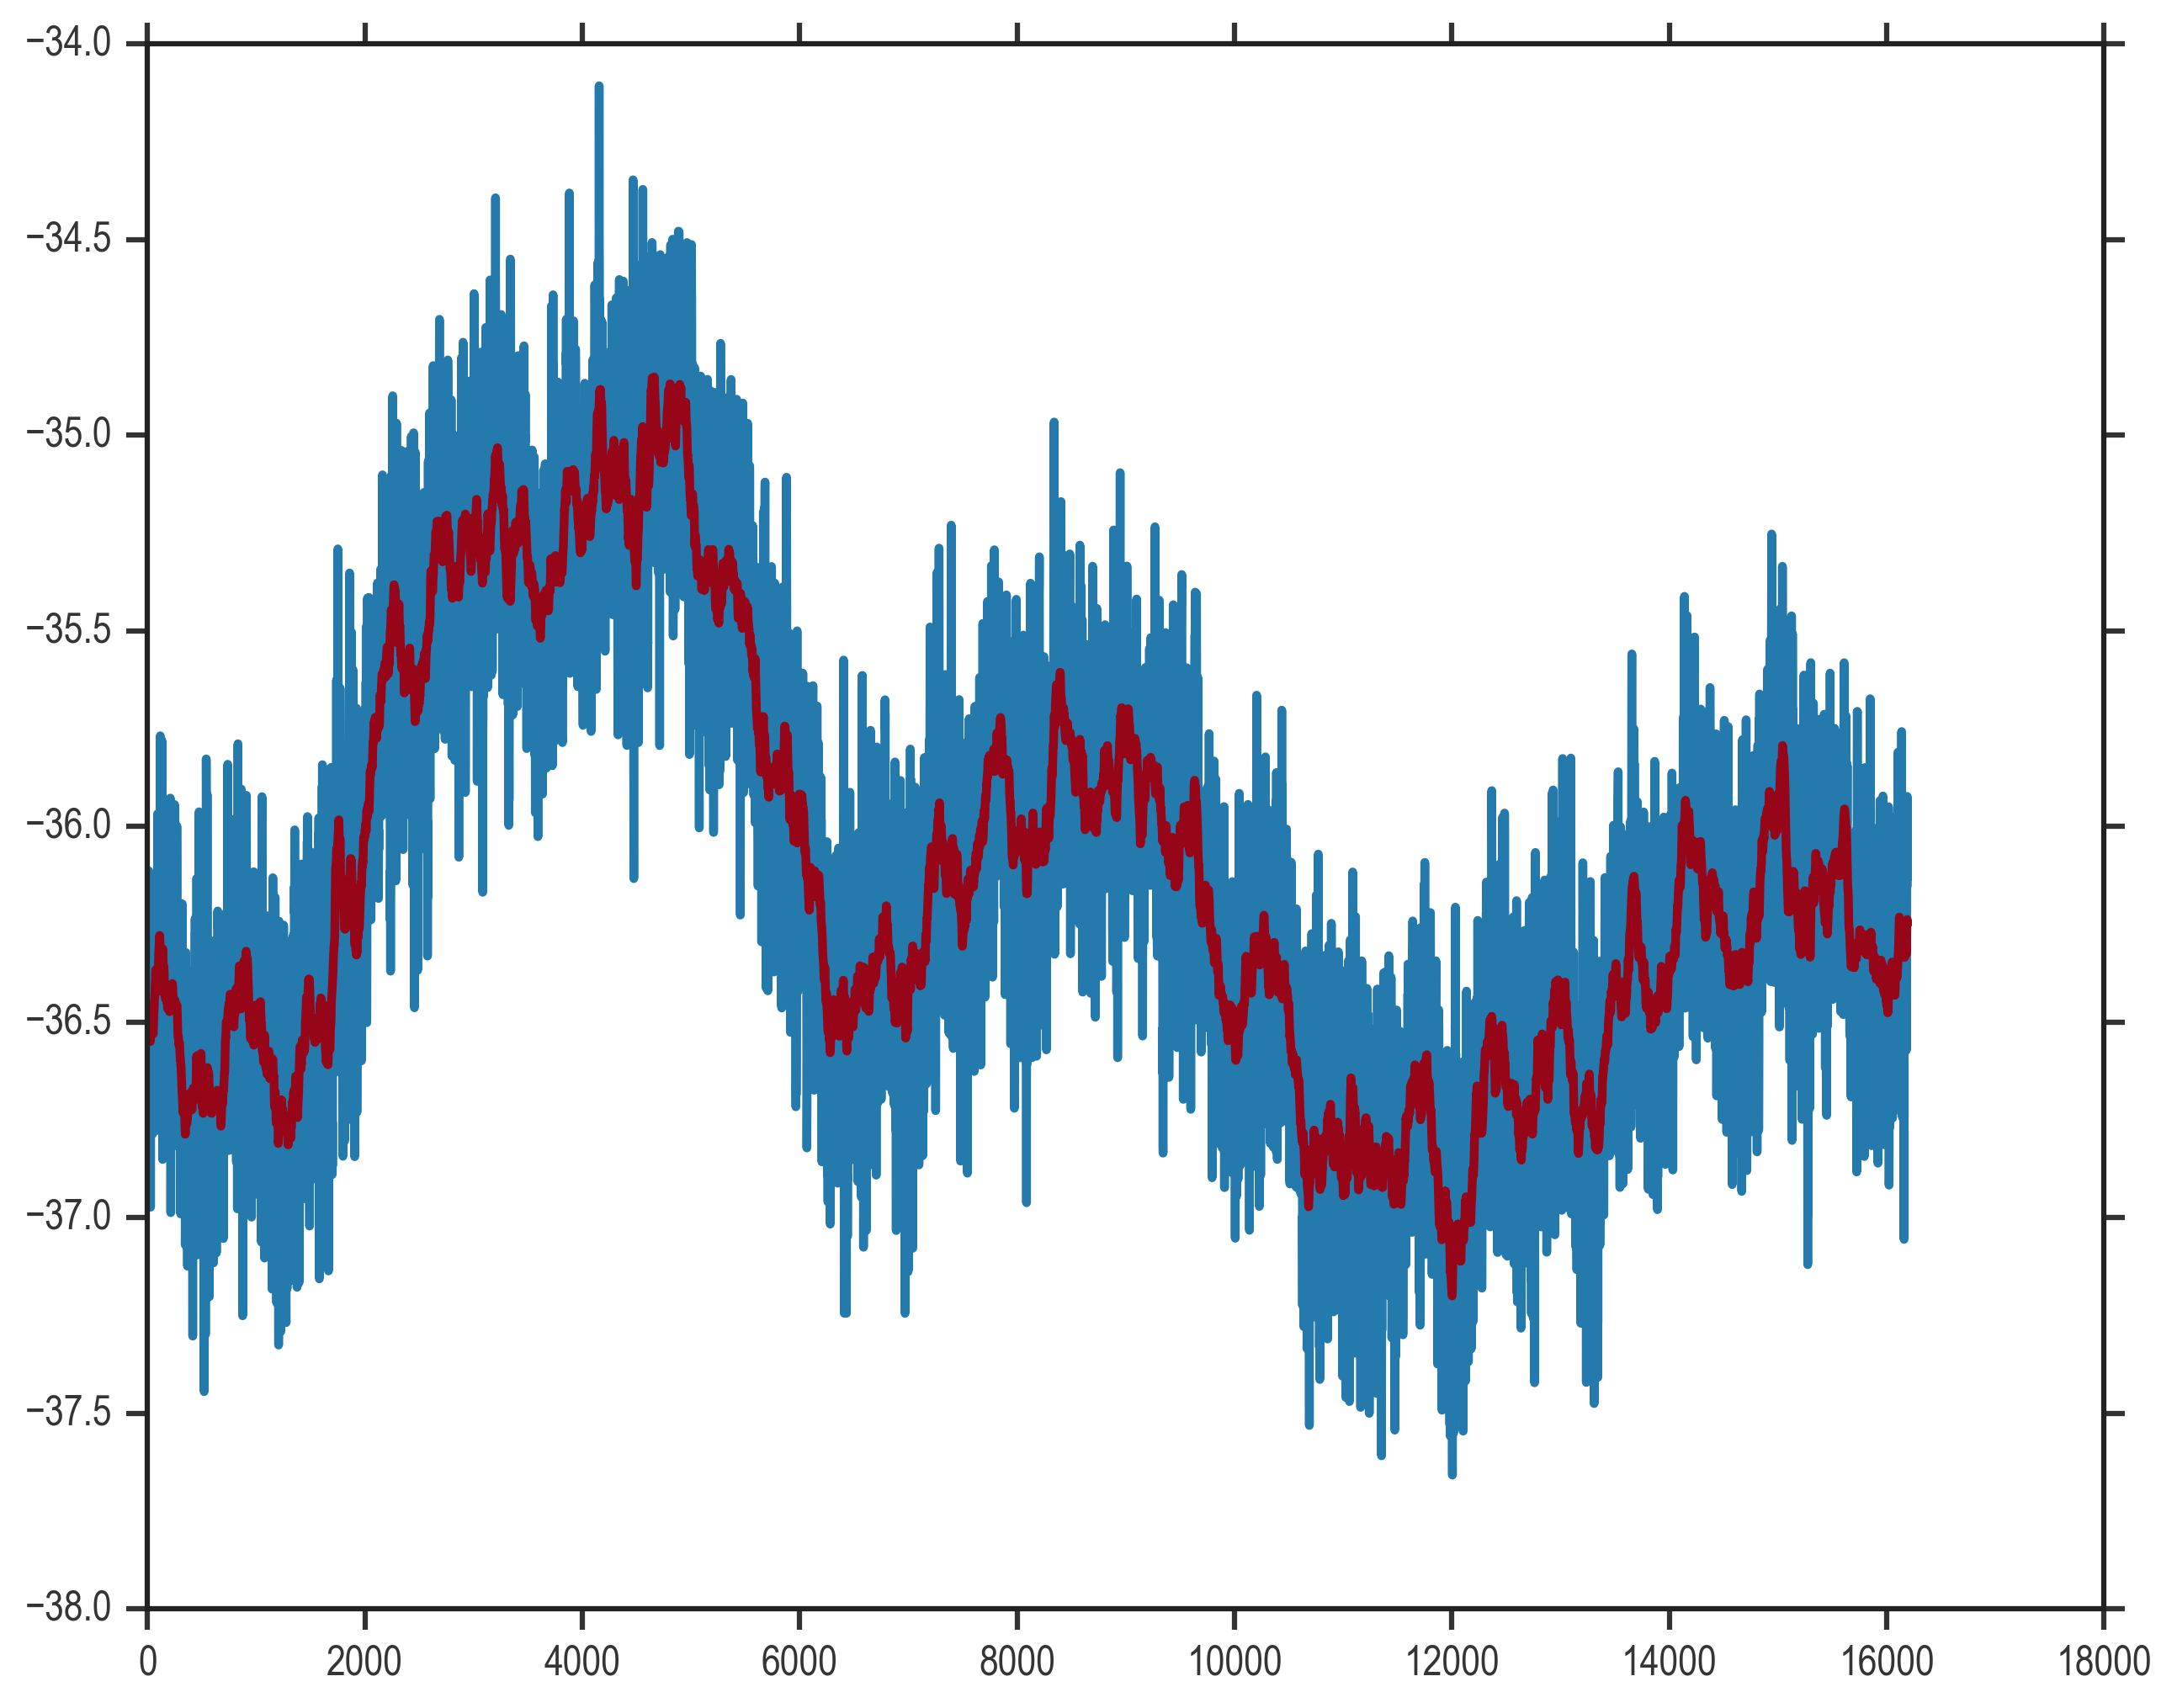

In [49]:
plt.plot(mem_pot)
plt.plot(smoothed_mem_pot)

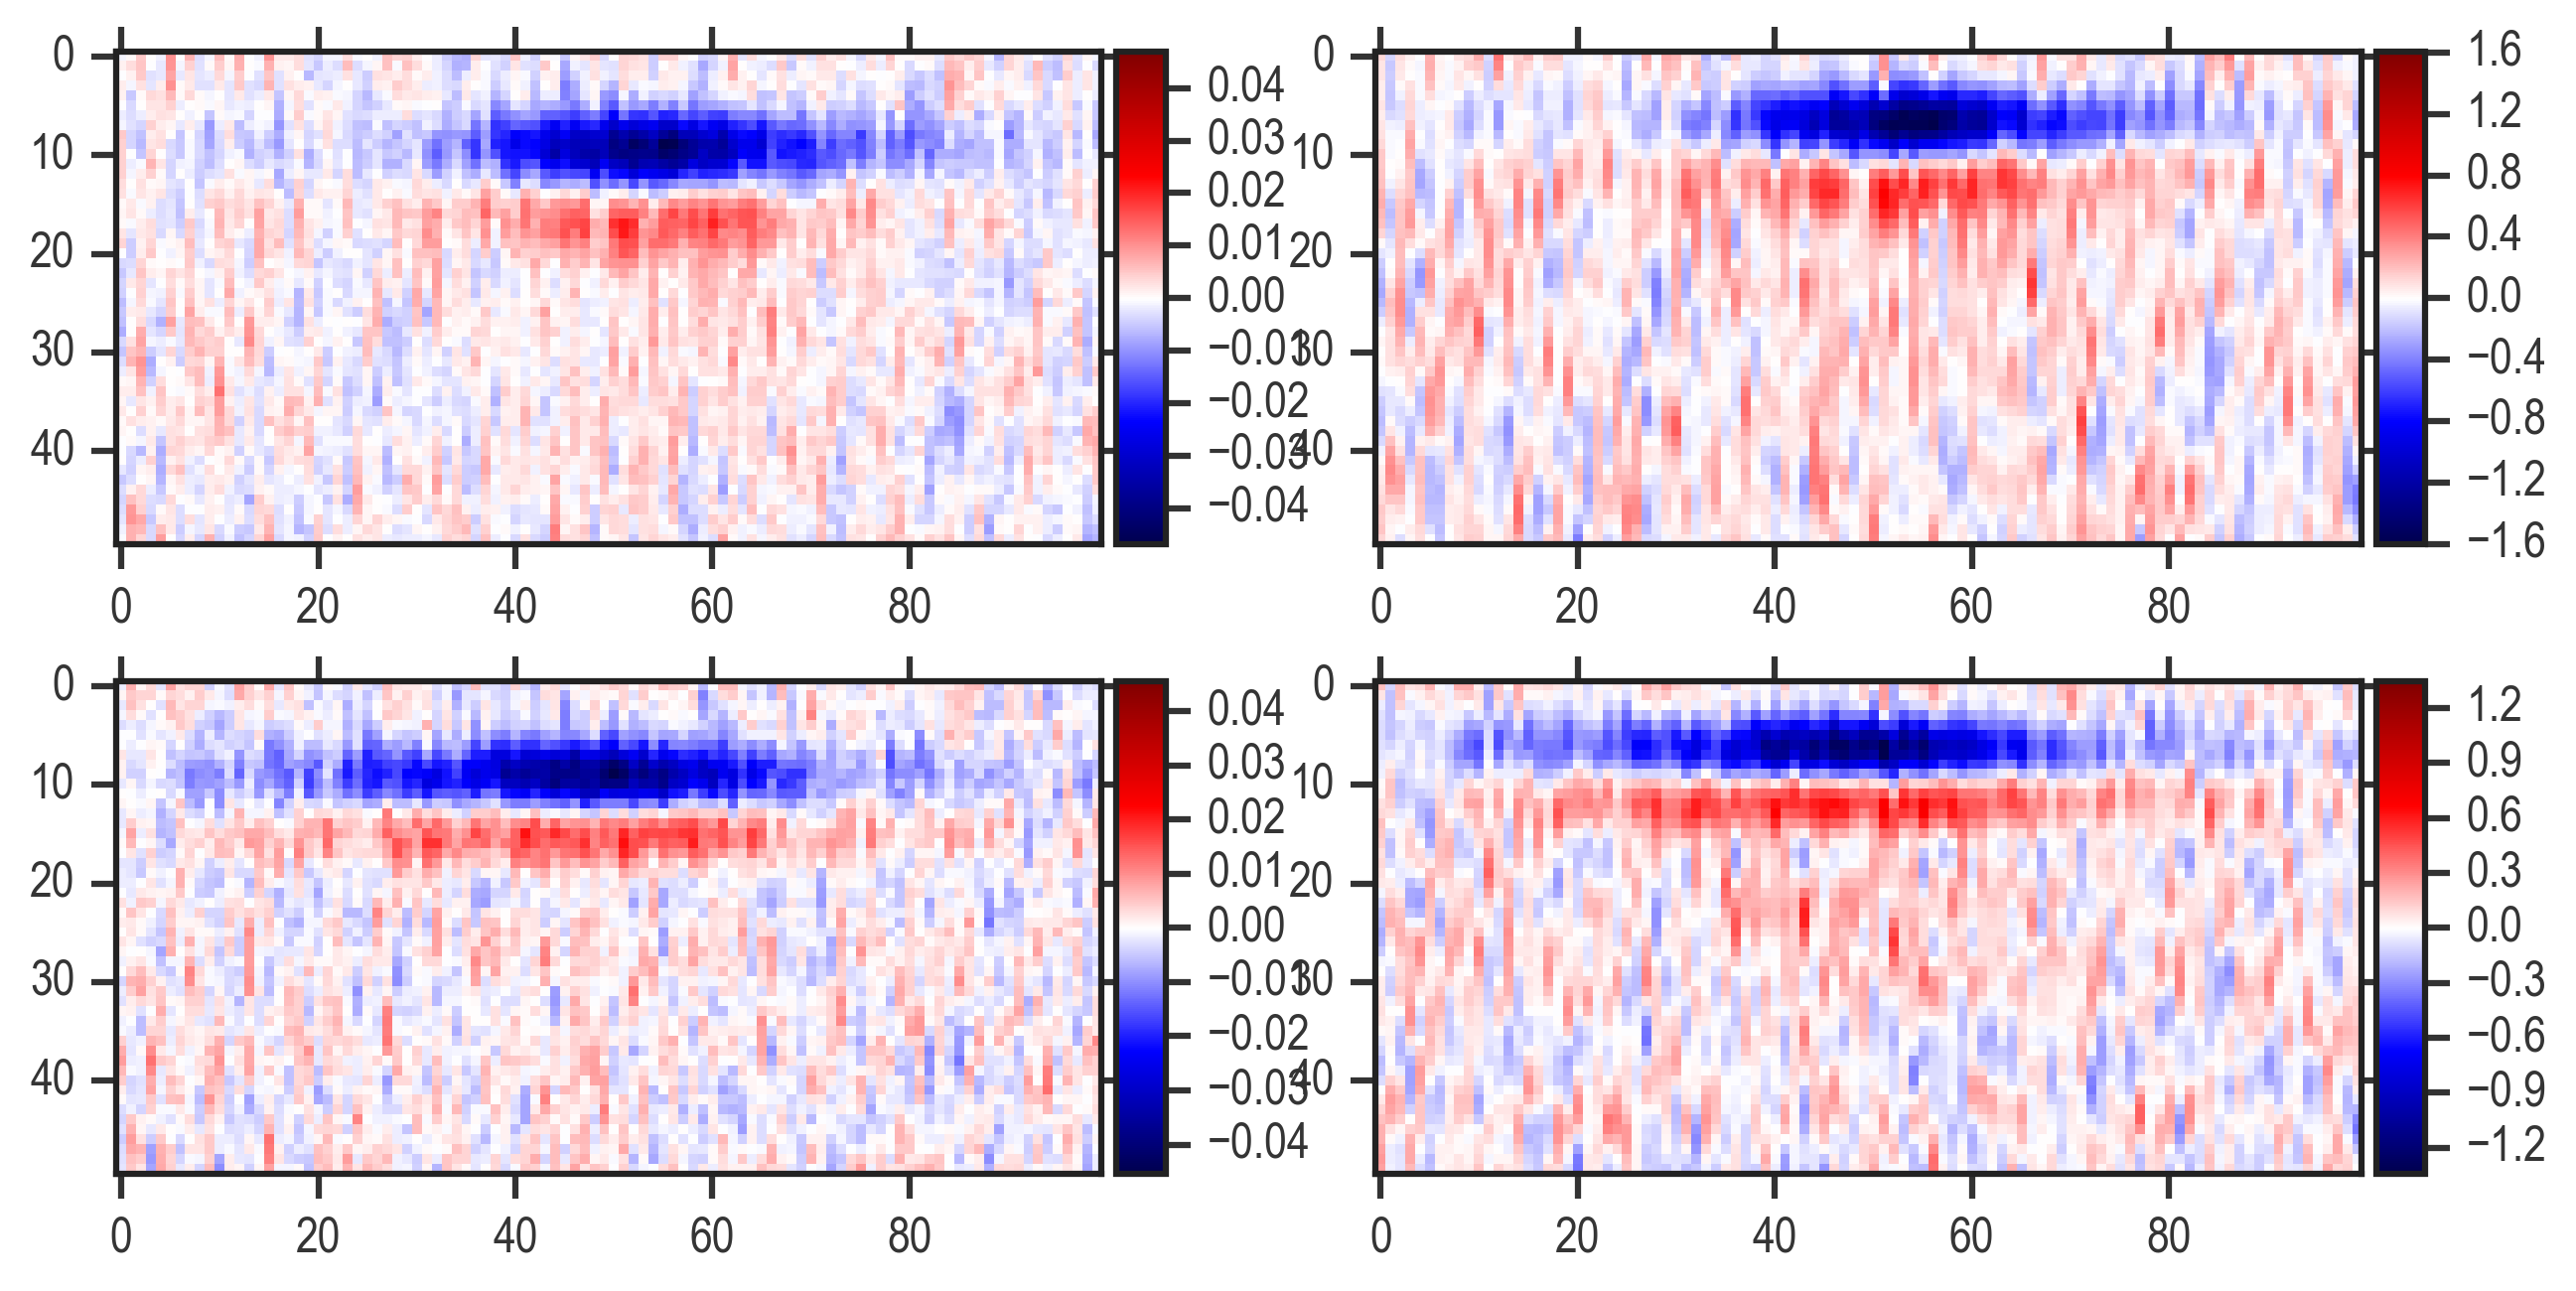

In [50]:
fig = plt.gcf()
fig.set_size_inches((10,5))
num_expts = len(h_rfs.keys())
for ide, expt in enumerate(sorted(h_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(h_rfs[expt], clim=[-np.max(abs(h_rfs[expt])), np.max(abs(h_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(h_recreated_rfs[expt], clim=[-np.max(abs(h_recreated_rfs[expt])),
                                                           np.max(abs(h_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [59]:
h_rfs = collections.defaultdict(list)
h_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + late_h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        h_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        detrended_mem_pot = np.array(f['lines/detrended_membrane_potential'])[ide]
        stimuli = np.array(f['lines/stimuli'])
        h_recreated_rf = np.zeros_like(h_rfs[expt])
        window_size = h_rfs[expt].shape[0]
        for t in range(window_size, len(detrended_mem_pot)):
            h_recreated_rf += stimuli[(t-window_size):t].astype('float') * detrended_mem_pot[t]
        h_recreated_rf /= (len(detrended_mem_pot) - window_size)
        h_recreated_rfs[expt] = h_recreated_rf[::-1]

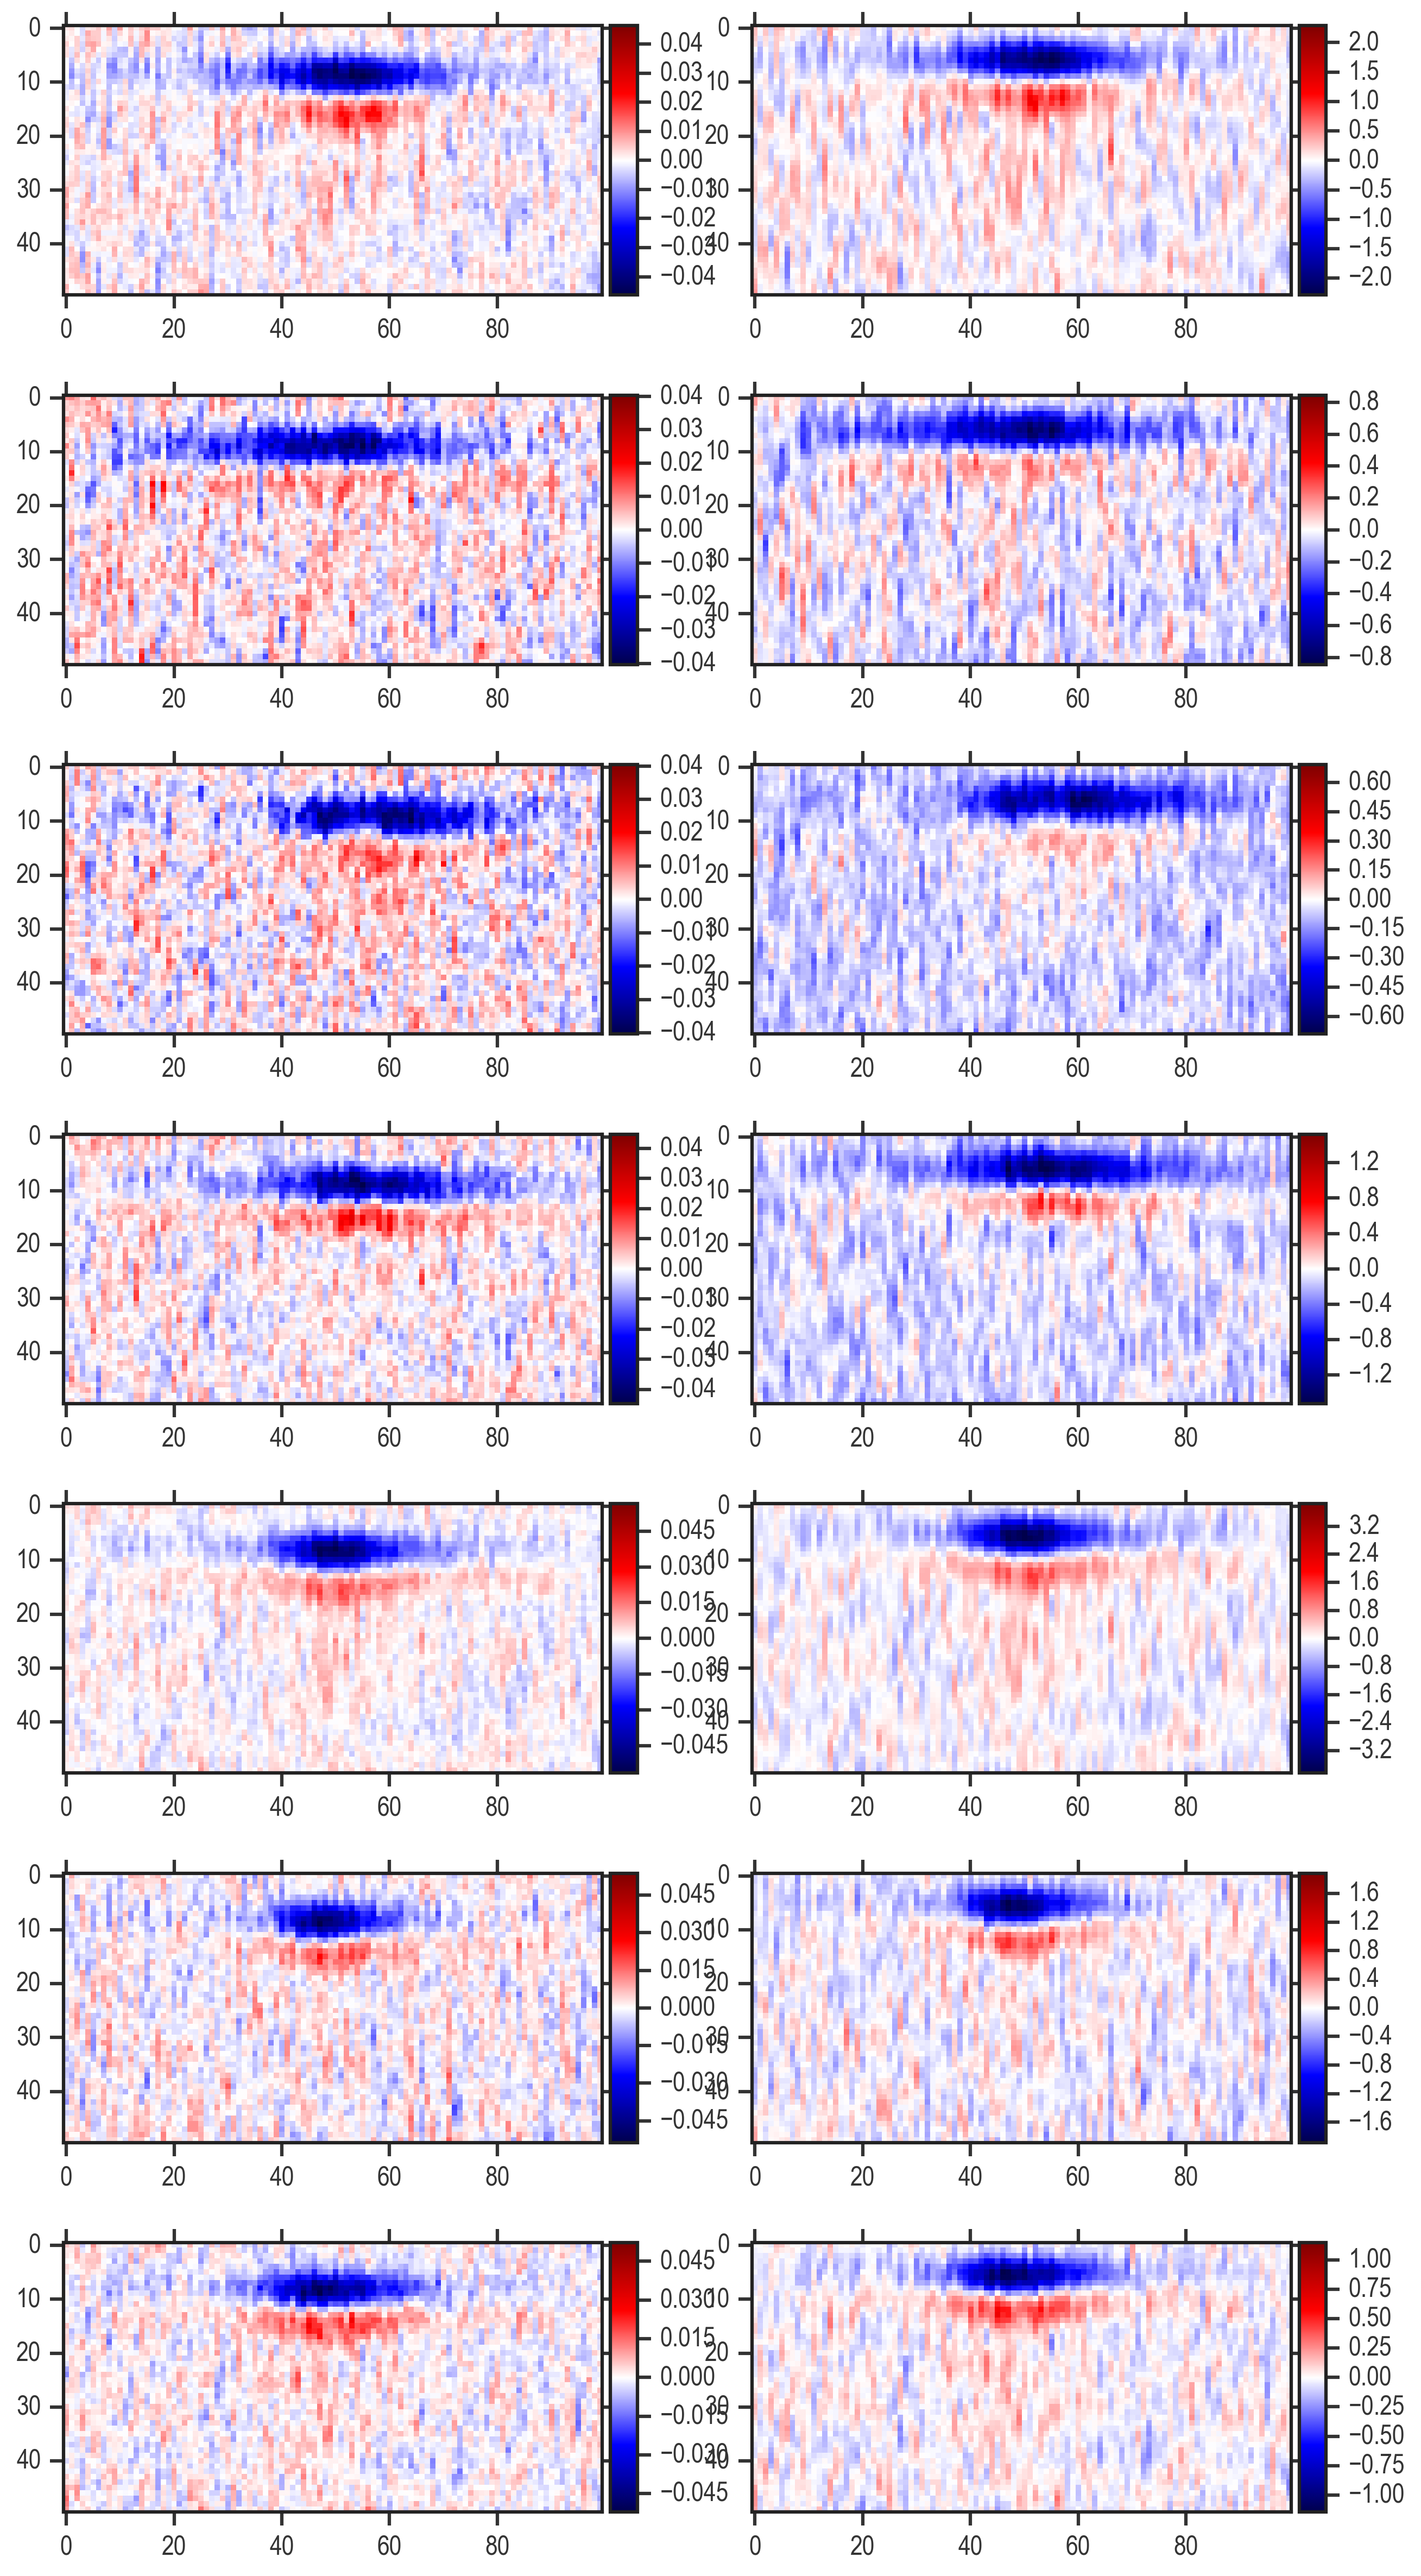

In [54]:
fig = plt.gcf()
fig.set_size_inches((10,20))
num_expts = len(h_rfs.keys())
for ide, expt in enumerate(sorted(h_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(h_rfs[expt], clim=[-np.max(abs(h_rfs[expt])), np.max(abs(h_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(h_recreated_rfs[expt], clim=[-np.max(abs(h_recreated_rfs[expt])),
                                                           np.max(abs(h_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

Another kind of detrending

In [57]:
window_size = 200

h_rfs = collections.defaultdict(list)
h_recreated_rfs_new_detrending = collections.defaultdict(list)
with h5py.File(data_dir + late_h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        h_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        mem_pot = np.array(f['lines/membrane_potential'])[ide]
        smoothed_mem_pot = np.zeros_like(mem_pot)

        for t in range(len(mem_pot)):
            start = np.max([0, (t-window_size//2)])
            stop = np.min([len(mem_pot)-1, (t+window_size//2)])
            smoothed_mem_pot[t] = np.mean(mem_pot[start:stop])
        stimuli = np.array(f['lines/stimuli'])
        h_recreated_rf = np.zeros_like(h_rfs[expt])
        window_size = h_rfs[expt].shape[0]
        for t in range(window_size, len(mem_pot)):
            h_recreated_rf += stimuli[(t-window_size+1):t+1].astype('float') * (mem_pot[t] - smoothed_mem_pot[t])
        h_recreated_rf /= (len(mem_pot) - window_size)
        h_recreated_rfs_new_detrending[expt] = h_recreated_rf[::-1]

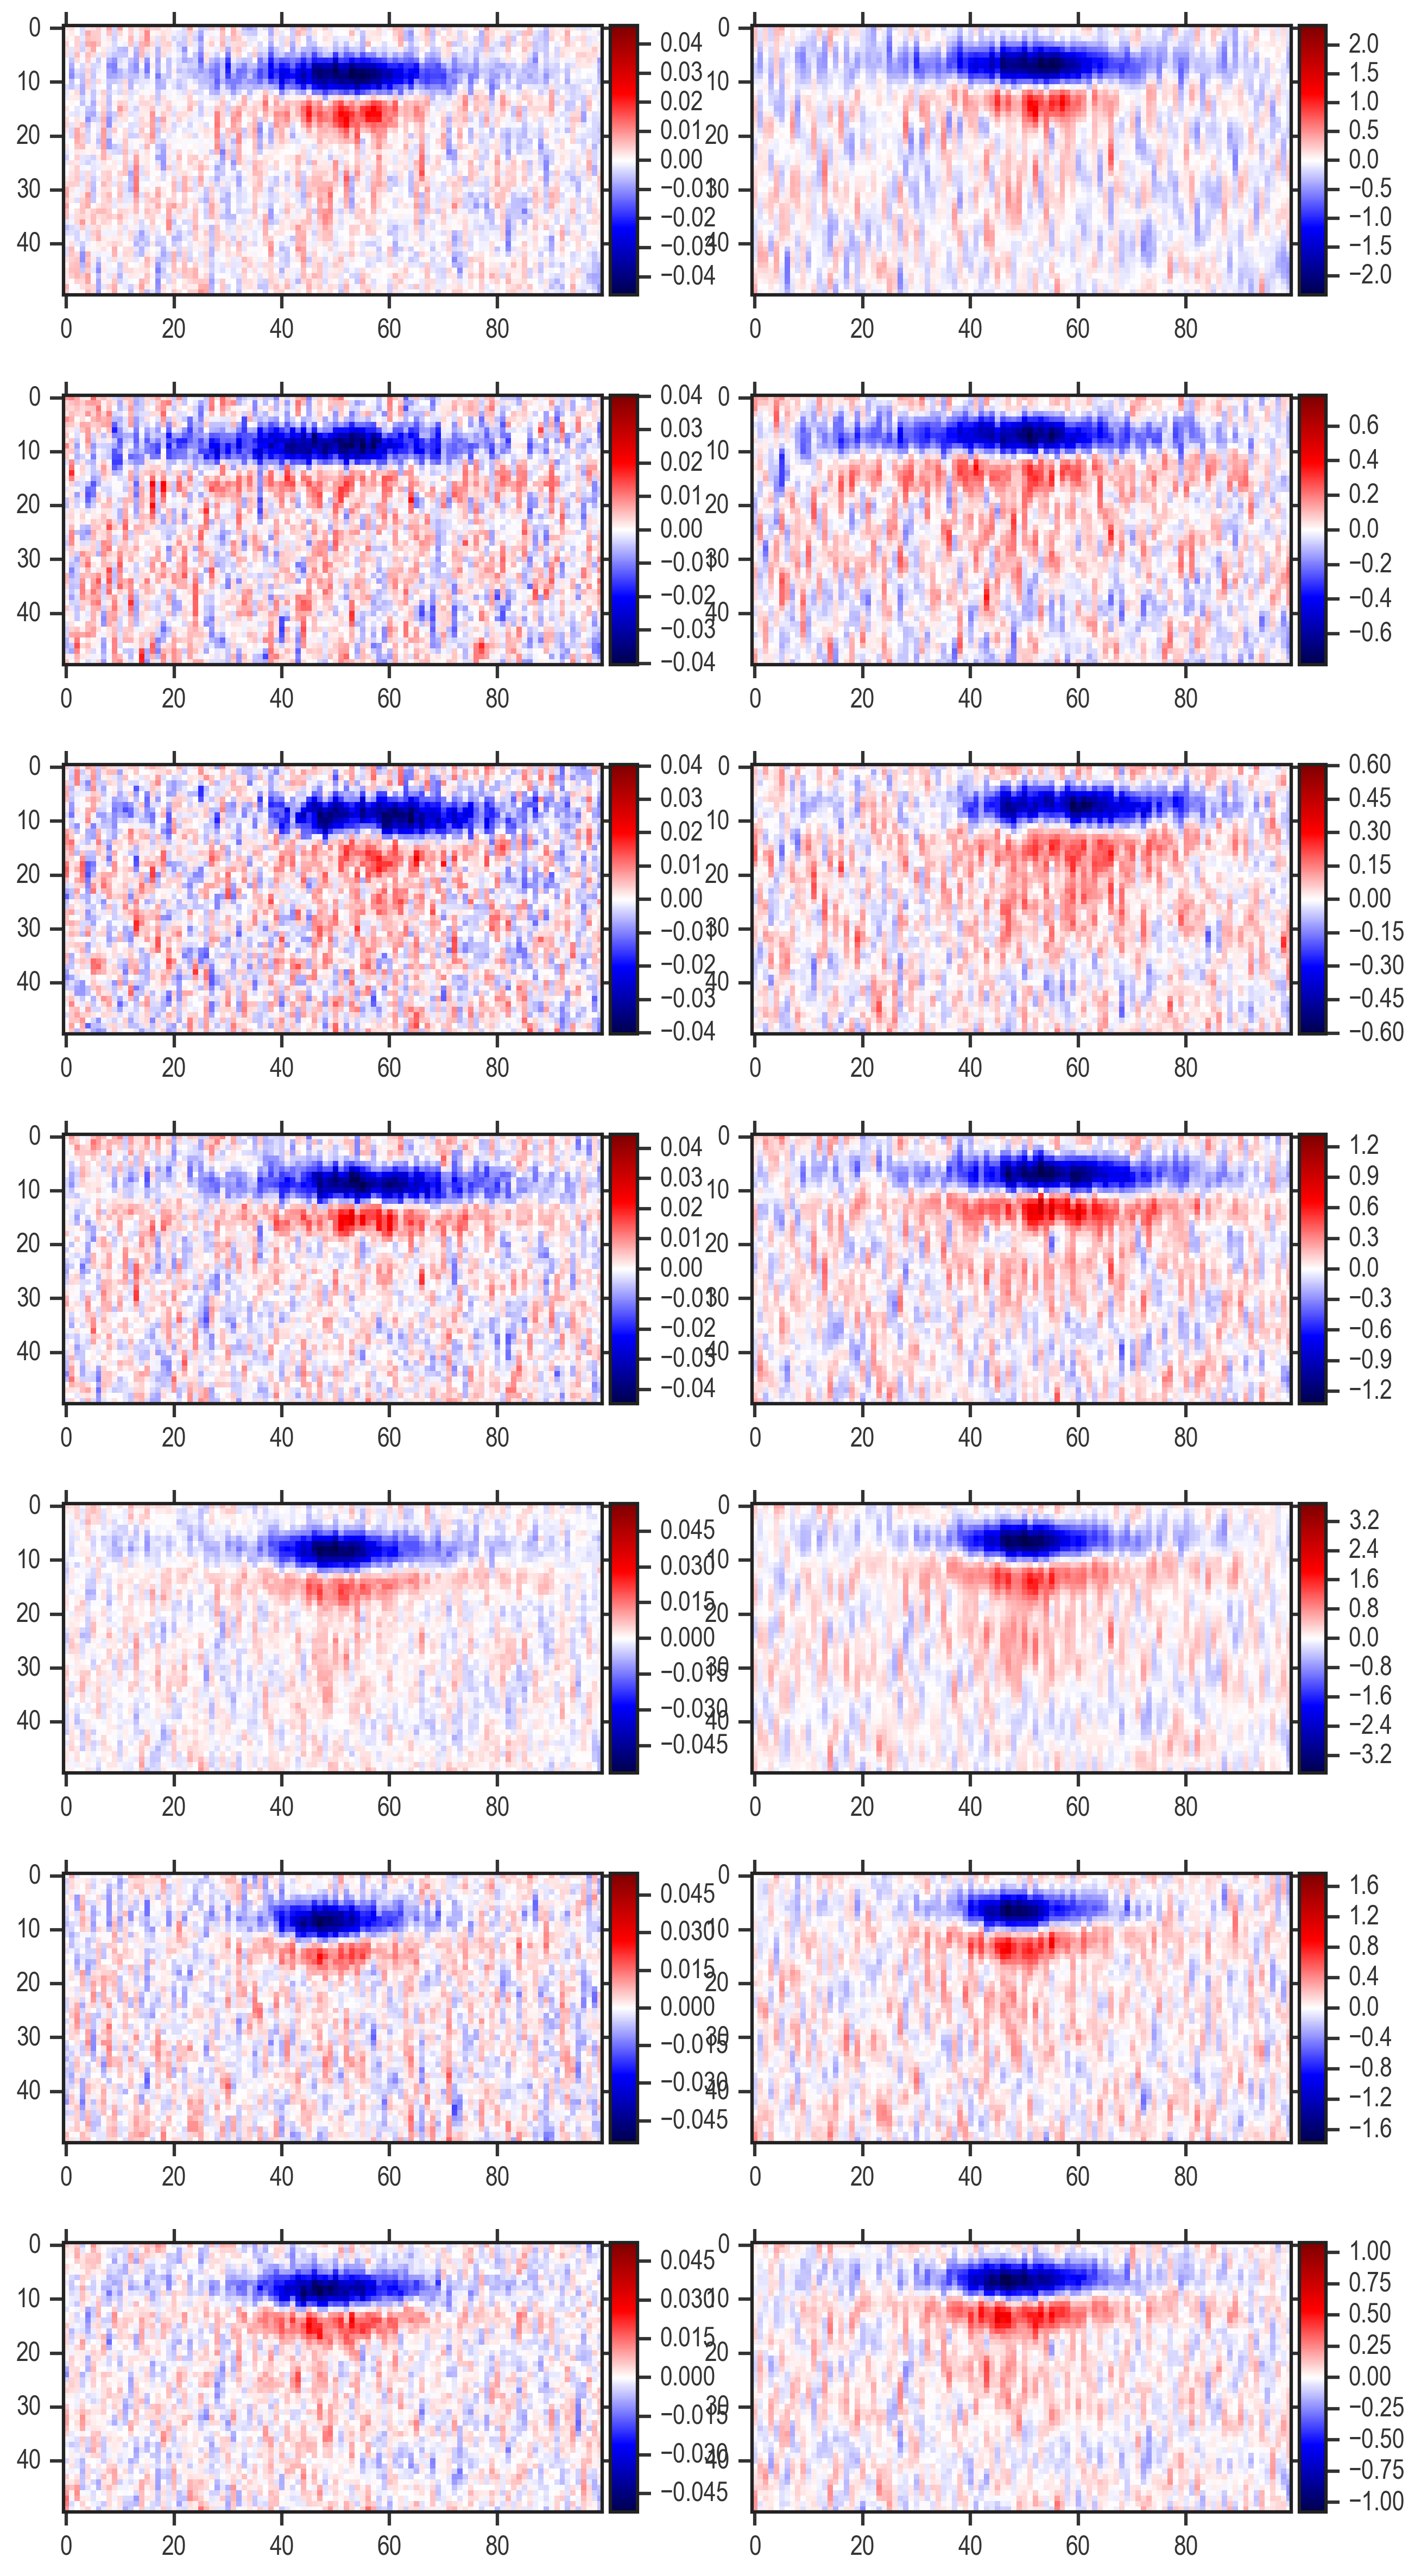

In [58]:
fig = plt.gcf()
fig.set_size_inches((10,20))
num_expts = len(h_rfs.keys())
for ide, expt in enumerate(sorted(h_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(h_rfs[expt], clim=[-np.max(abs(h_rfs[expt])), np.max(abs(h_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(h_recreated_rfs_new_detrending[expt], clim=[-np.max(abs(h_recreated_rfs_new_detrending[expt])),
                                                           np.max(abs(h_recreated_rfs_new_detrending[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

#### Side-by-side comparison of my two detrending methods

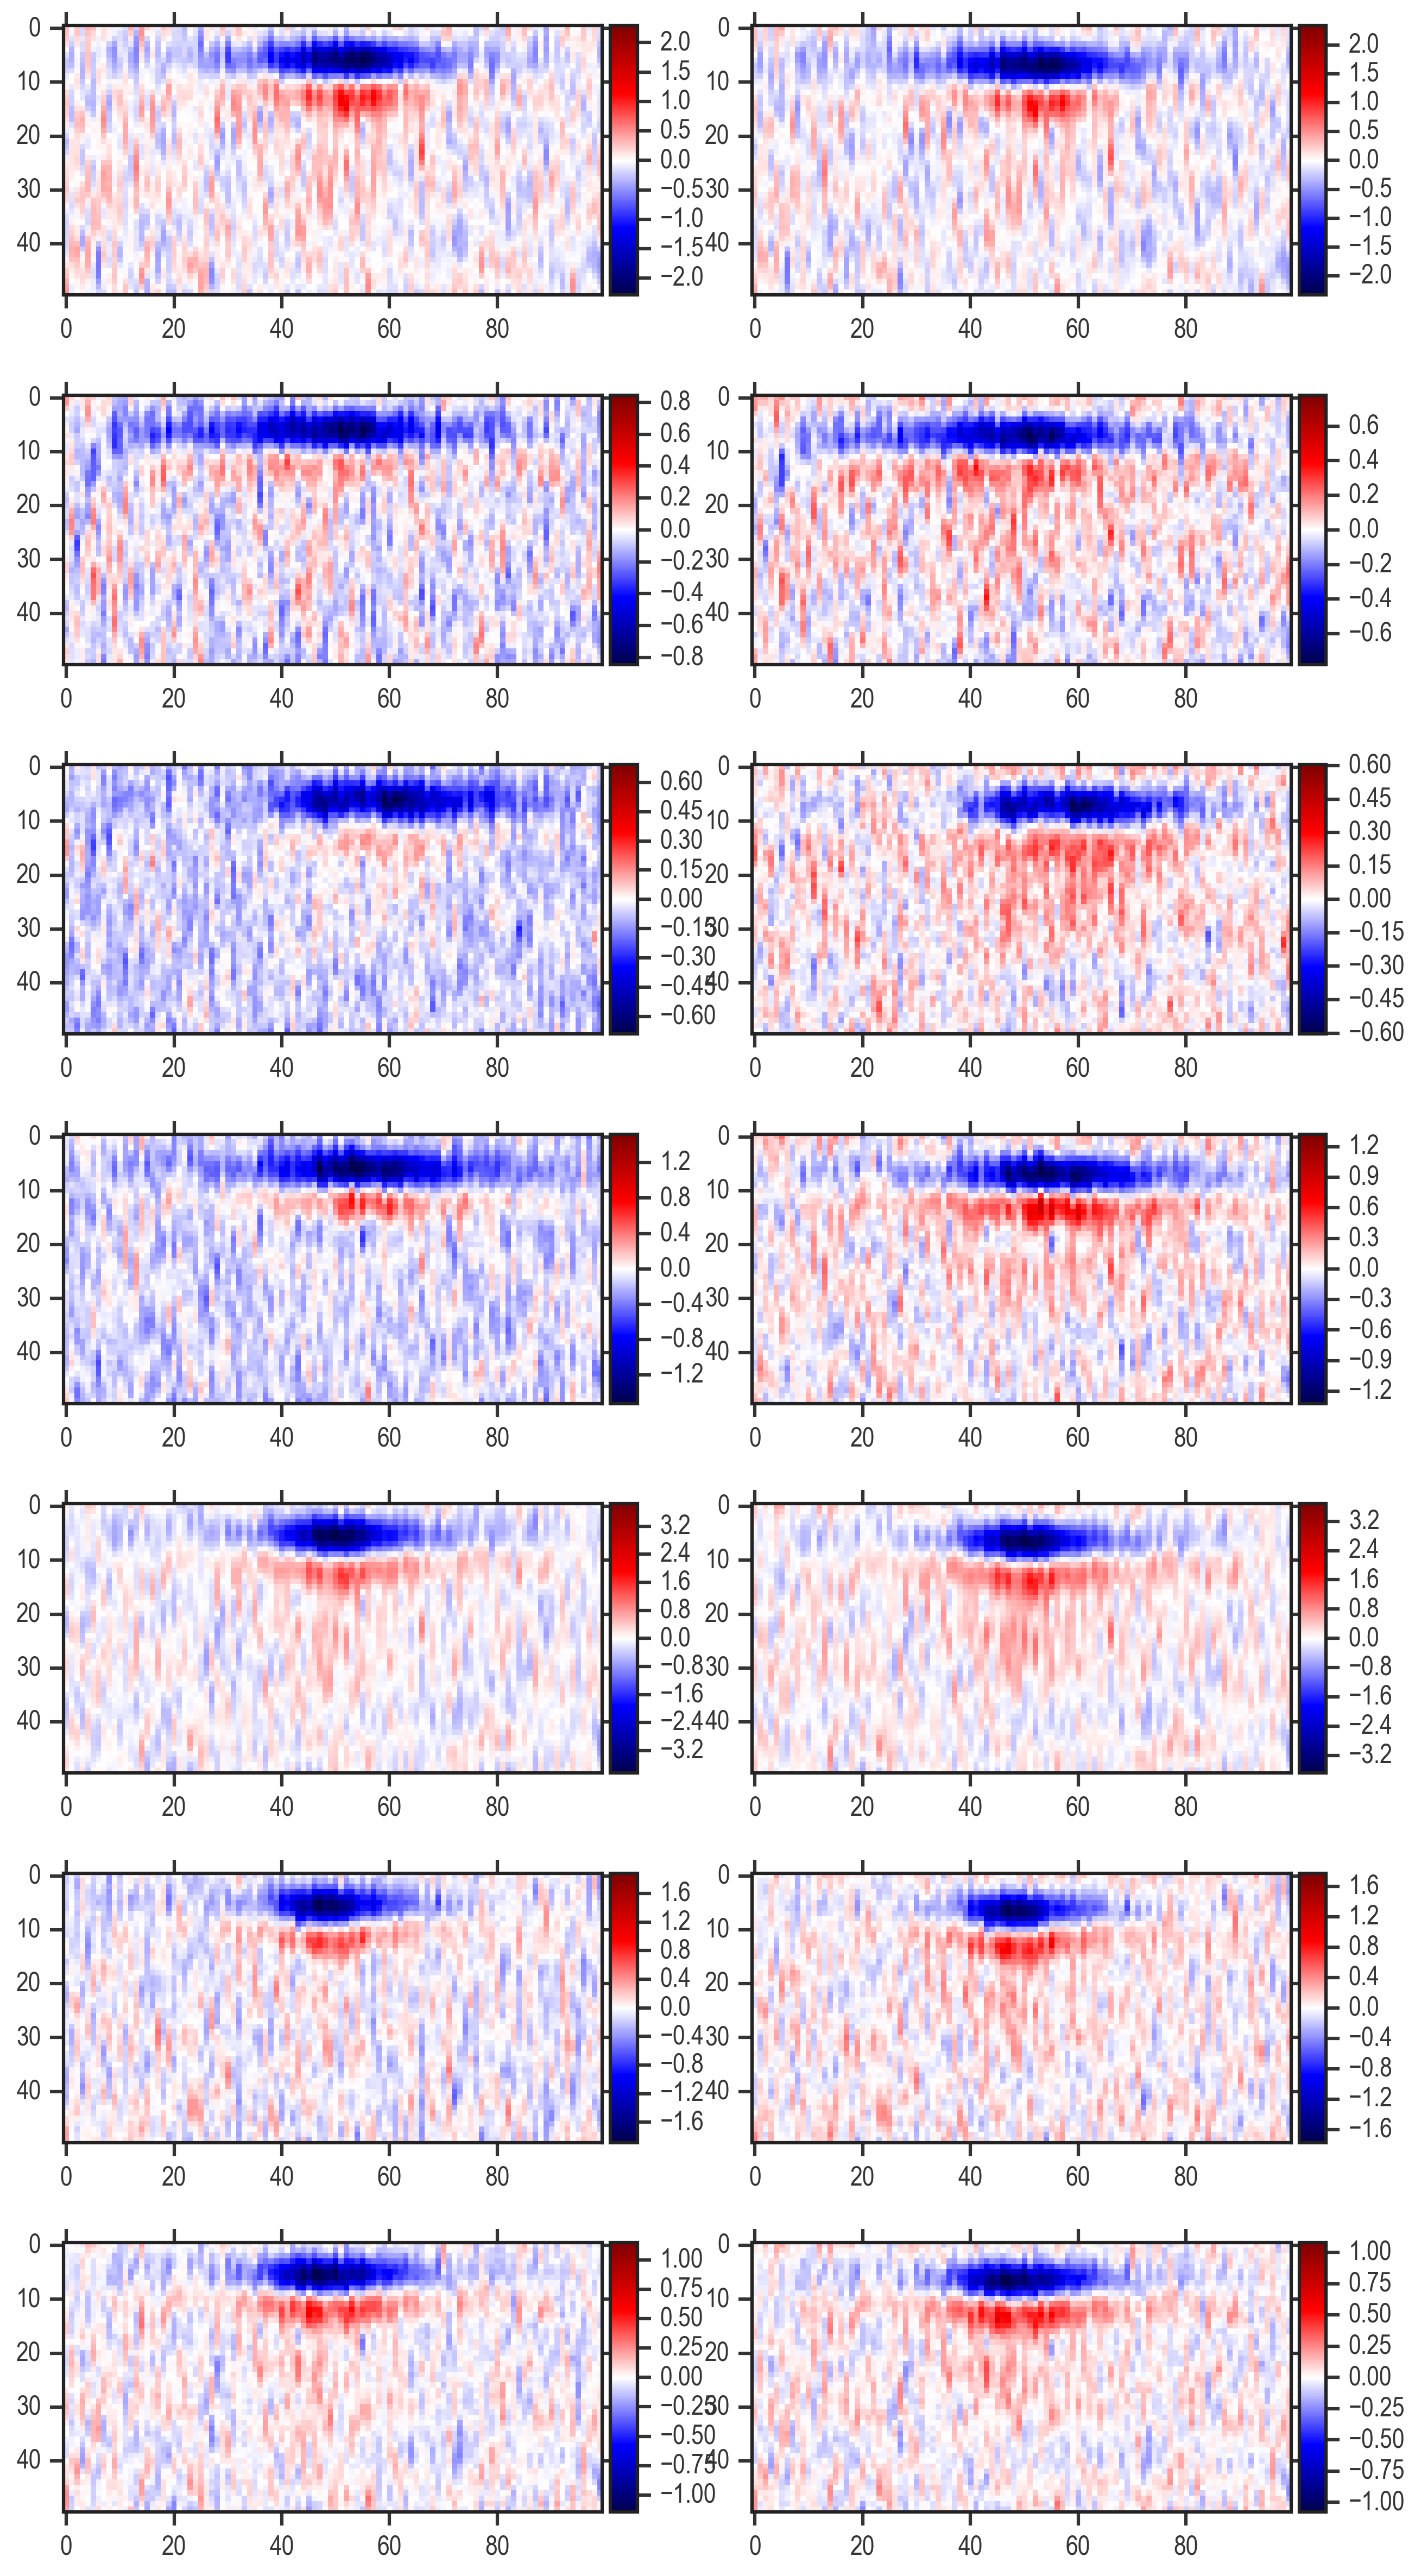

In [60]:
fig = plt.gcf()
fig.set_size_inches((10,20))
num_expts = len(h_rfs.keys())
for ide, expt in enumerate(sorted(h_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(h_recreated_rfs[expt], clim=[-np.max(abs(h_recreated_rfs[expt])), 
                                                 np.max(abs(h_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(h_recreated_rfs_new_detrending[expt], clim=[-np.max(abs(h_recreated_rfs_new_detrending[expt])),
                                                           np.max(abs(h_recreated_rfs_new_detrending[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Amacrine cells

#### Early

In [61]:
a_rfs = collections.defaultdict(list)
a_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + early_a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        a_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        detrended_mem_pot = np.array(f['lines/detrended_membrane_potential'])[ide]
        stimuli = np.array(f['lines/stimuli'])
        a_recreated_rf = np.zeros_like(a_rfs[expt])
        window_size = a_rfs[expt].shape[0]
        for t in range(window_size, len(detrended_mem_pot)):
            a_recreated_rf += stimuli[(t-window_size):t].astype('float') * detrended_mem_pot[t]
        a_recreated_rf /= (len(detrended_mem_pot) - window_size)
        a_recreated_rfs[expt] = a_recreated_rf[::-1]

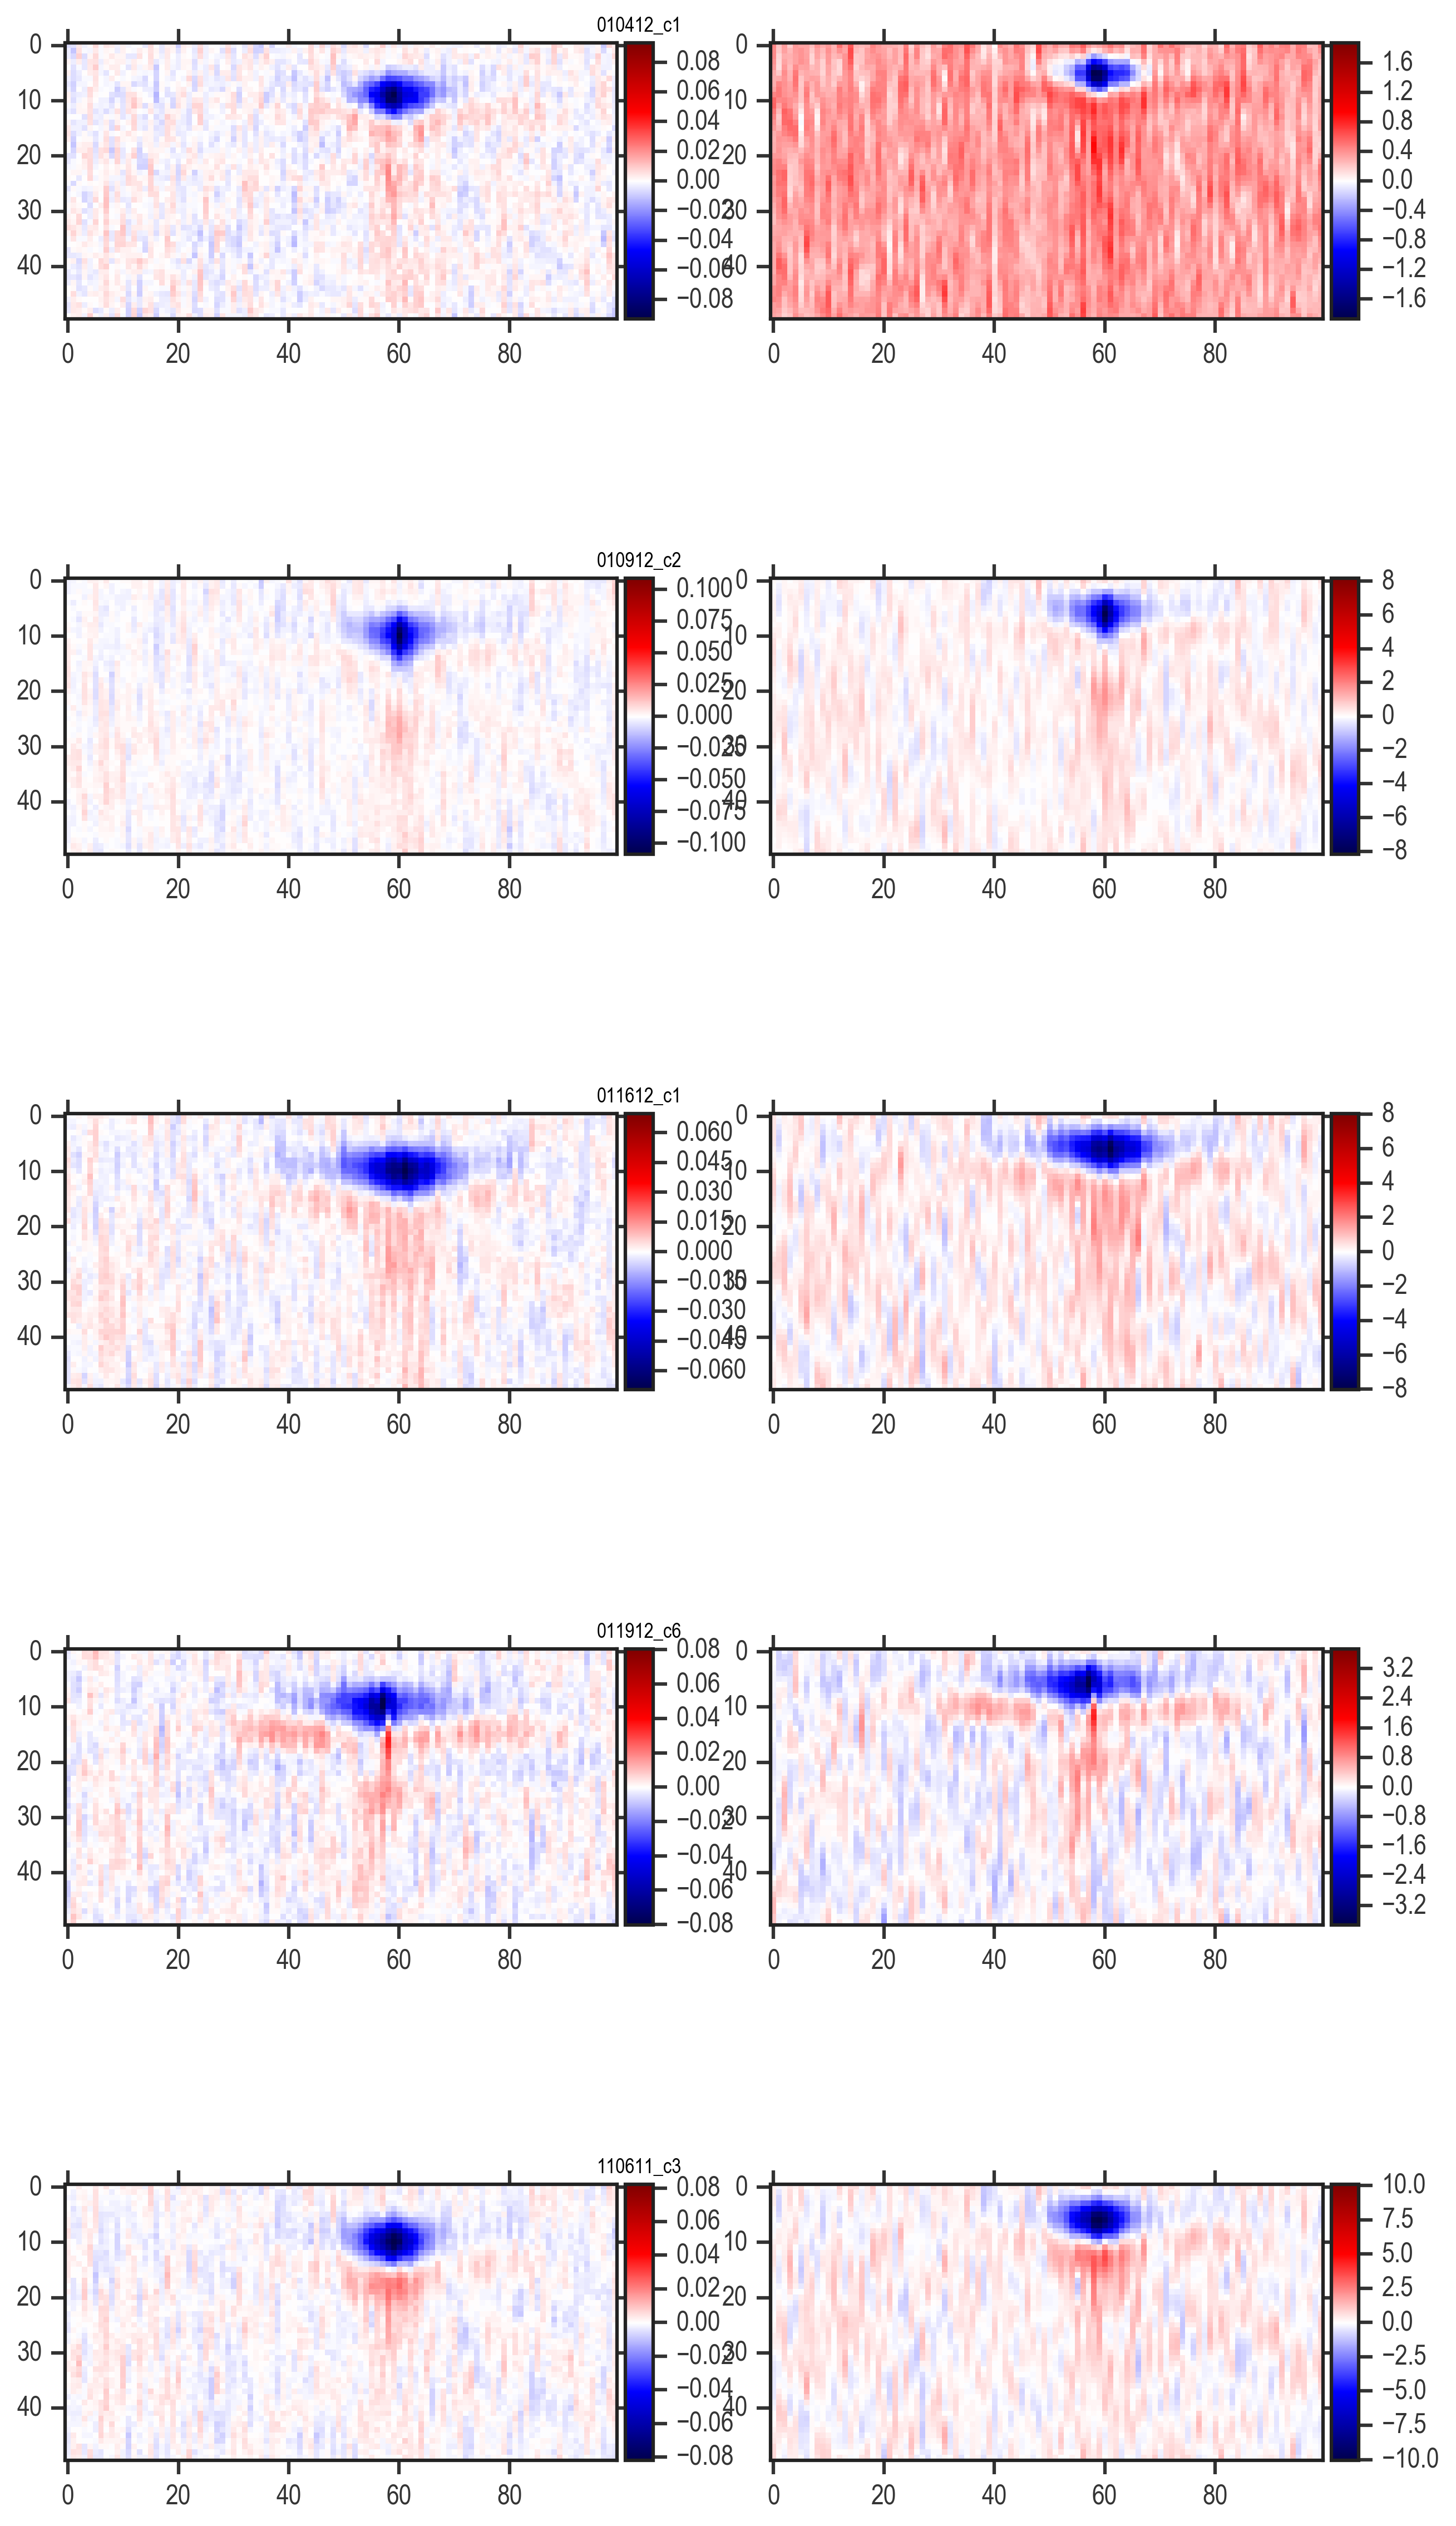

In [63]:
fig = plt.gcf()
fig.set_size_inches((10,20))
num_expts = len(a_rfs.keys())
for ide, expt in enumerate(sorted(a_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(a_rfs[expt], clim=[-np.max(abs(a_rfs[expt])), np.max(abs(a_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.title(expt, fontsize=9)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(a_recreated_rfs[expt], clim=[-np.max(abs(a_recreated_rfs[expt])),
                                                           np.max(abs(a_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

#### Late

In [64]:
a_rfs = collections.defaultdict(list)
a_recreated_rfs = collections.defaultdict(list)
with h5py.File(data_dir + late_a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        a_rfs[expt] = np.array(f['lines/rfs/%s' %expt])
        detrended_mem_pot = np.array(f['lines/detrended_membrane_potential'])[ide]
        stimuli = np.array(f['lines/stimuli'])
        a_recreated_rf = np.zeros_like(a_rfs[expt])
        window_size = a_rfs[expt].shape[0]
        for t in range(window_size, len(detrended_mem_pot)):
            a_recreated_rf += stimuli[(t-window_size):t].astype('float') * detrended_mem_pot[t]
        a_recreated_rf /= (len(detrended_mem_pot) - window_size)
        a_recreated_rfs[expt] = a_recreated_rf[::-1]

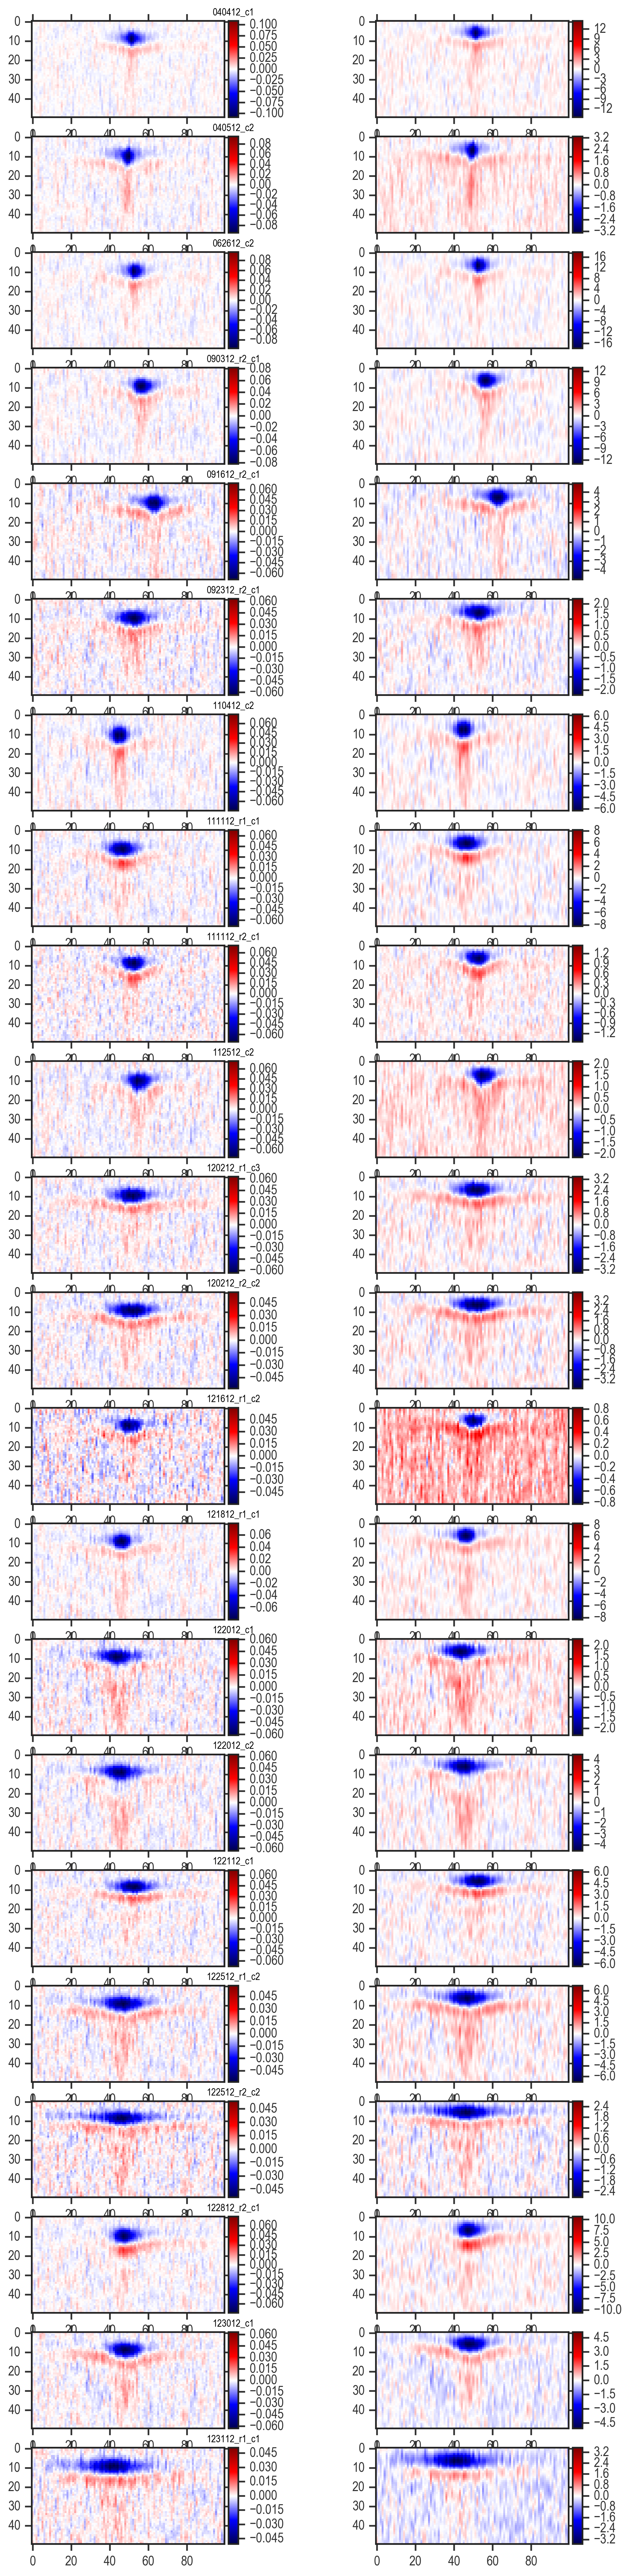

In [65]:
fig = plt.gcf()
fig.set_size_inches((10,40))
num_expts = len(a_rfs.keys())
for ide, expt in enumerate(sorted(a_rfs.keys())):
    ax = plt.subplot(num_expts, 2, 2*ide+1)
    im = plt.imshow(a_rfs[expt], clim=[-np.max(abs(a_rfs[expt])), np.max(abs(a_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.title(expt, fontsize=9)

    ax = plt.subplot(num_expts, 2, 2*ide+2)
    im = plt.imshow(a_recreated_rfs[expt], clim=[-np.max(abs(a_recreated_rfs[expt])),
                                                           np.max(abs(a_recreated_rfs[expt]))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)